In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [6]:
data_dir = 'data'

transform = transforms.Compose([
                transforms.Resize(256),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(type(dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


<class 'torchvision.datasets.folder.ImageFolder'>


In [7]:
class EyeCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(EyeCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(50176, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.classifier(x)


In [8]:
def get_resnet_model(num_classes=5):
    resnet = models.resnet18(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad = False
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
    return resnet


In [9]:
def train(model, name, epochs=4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"{name} | Epoch {epoch+1} [Train]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"{name} | Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{name} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title(f'{name} Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


CustomCNN | Epoch 1 [Train]: 100%|████████████| 188/188 [02:32<00:00,  1.23it/s]


CustomCNN | Epoch 1/10 | Train Loss: 0.9517, Train Acc: 61.48% | Val Loss: 0.4930, Val Acc: 80.60%


CustomCNN | Epoch 2 [Train]: 100%|████████████| 188/188 [02:25<00:00,  1.29it/s]


CustomCNN | Epoch 2/10 | Train Loss: 0.4164, Train Acc: 84.88% | Val Loss: 0.2342, Val Acc: 91.67%


CustomCNN | Epoch 3 [Train]: 100%|████████████| 188/188 [02:56<00:00,  1.07it/s]


CustomCNN | Epoch 3/10 | Train Loss: 0.2659, Train Acc: 90.65% | Val Loss: 0.1488, Val Acc: 95.47%


CustomCNN | Epoch 4 [Train]: 100%|████████████| 188/188 [03:05<00:00,  1.01it/s]


CustomCNN | Epoch 4/10 | Train Loss: 0.2094, Train Acc: 92.75% | Val Loss: 0.0986, Val Acc: 97.53%


CustomCNN | Epoch 5 [Train]: 100%|████████████| 188/188 [02:30<00:00,  1.25it/s]


CustomCNN | Epoch 5/10 | Train Loss: 0.1657, Train Acc: 94.12% | Val Loss: 0.0805, Val Acc: 97.67%


CustomCNN | Epoch 6 [Train]: 100%|████████████| 188/188 [02:39<00:00,  1.18it/s]


CustomCNN | Epoch 6/10 | Train Loss: 0.1483, Train Acc: 94.63% | Val Loss: 0.0595, Val Acc: 98.47%


CustomCNN | Epoch 7 [Train]: 100%|████████████| 188/188 [02:33<00:00,  1.23it/s]


CustomCNN | Epoch 7/10 | Train Loss: 0.1263, Train Acc: 95.58% | Val Loss: 0.1130, Val Acc: 96.40%


CustomCNN | Epoch 8 [Train]: 100%|████████████| 188/188 [02:33<00:00,  1.23it/s]


CustomCNN | Epoch 8/10 | Train Loss: 0.1193, Train Acc: 95.82% | Val Loss: 0.0617, Val Acc: 97.87%


CustomCNN | Epoch 9 [Train]: 100%|████████████| 188/188 [02:31<00:00,  1.24it/s]


CustomCNN | Epoch 9/10 | Train Loss: 0.0990, Train Acc: 96.73% | Val Loss: 0.0394, Val Acc: 98.93%


CustomCNN | Epoch 10 [Train]: 100%|███████████| 188/188 [02:30<00:00,  1.25it/s]


CustomCNN | Epoch 10/10 | Train Loss: 0.0933, Train Acc: 97.02% | Val Loss: 0.0572, Val Acc: 98.87%


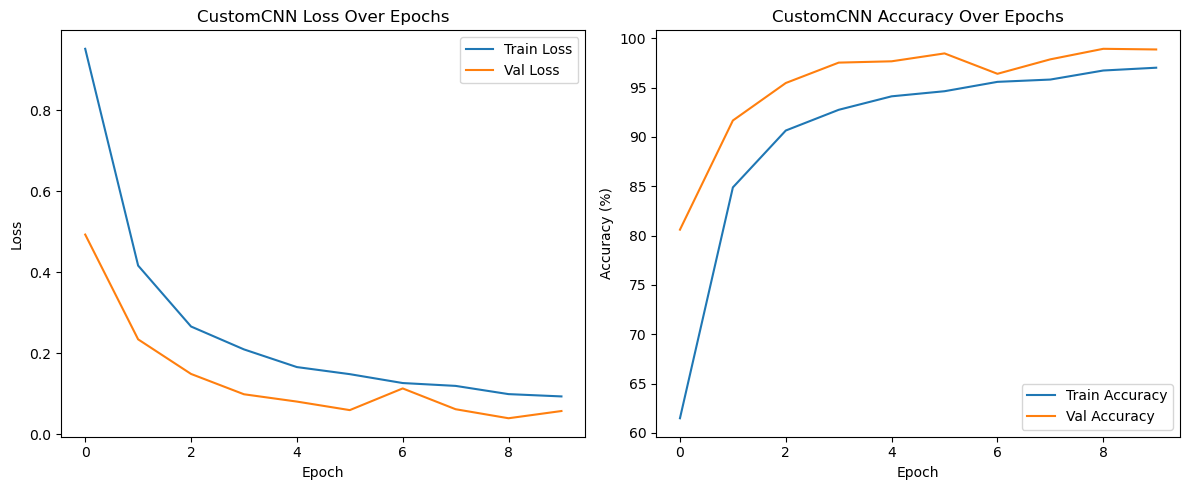

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model 1: CNN from scratch
cnn_model = EyeCNN()
train(cnn_model, "CustomCNN", epochs=10)


In [13]:
torch.save(cnn_model.state_dict(), 'CNN_model.pkl')